YOLOV5对于输入的数据集有要求因此对原始数据进行处理

In [1]:
import os
import glob
import h5py
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from cv2 import cv2
import shutil

检查、创建目录

In [2]:
absfile = os.path.abspath(os.path.join(os.getcwd(), ".."))#获取绝对路径
path_to_digit_struct_mat_file = [os.getcwd()+'\\data\\train\\digitStruct.mat',os.getcwd()+'\\data\\test\\digitStruct.mat']
#找到原数据集的结构文件

In [15]:
datafile = {
    'origenal_train':os.path.join(absfile,'data\\train'),
    'origenal_test':os.path.join(absfile,'data\\test'),
    'YOLO_train':os.path.join(absfile,'YOLO\\data\\train\\images'),
    'YOLO_train_label':os.path.join(absfile,'YOLO\\data\\train\\labels'),
    'YOLO_valid':os.path.join(absfile,'YOLO\\data\\valid\\images'),
    'YOLO_valid_label':os.path.join(absfile,'YOLO\\data\\valid\\labels'),
    'YOLO_test':os.path.join(absfile,'YOLO\\data\\test\\images' ),
    'YOLO_test_label':os.path.join(absfile,'YOLO\\data\\test\\labels' ),
    'origenal_digit_struct_train':os.path.join(absfile,'data\\train\\digitStruct.mat'),
    'origenal_digit_struct_test':os.path.join(absfile,'data\\test\\digitStruct.mat')
}
# 整理成字典
for i in datafile:
    print(i)
def check_dir(absfile,datafile):
    for i in datafile:
        if os.path.exists(datafile[i]):
            pass
        else:
            os.makedirs(datafile[i])
check_dir(absfile,datafile)
#检查路径是否正确 如果没有建立目录则建立

origenal_train
origenal_test
YOLO_train
YOLO_train_label
YOLO_valid
YOLO_valid_label
YOLO_test
YOLO_test_label
origenal_digit_struct_train
origenal_digit_struct_test


## 获取图像目录

In [4]:
image_train_file = glob.glob(os.path.join(datafile['origenal_train'],'*png'))
image_test_file = glob.glob(os.path.join(datafile['origenal_test'],'*png'))

image_train_file.sort(key = lambda x:int(x.split('\\')[-1][:-4]))
image_test_file.sort(key = lambda x:int(x.split('\\')[-1][:-4]))
image_train_file[0:5]
image_file={'train':image_train_file,'test':image_test_file}
del image_train_file,image_test_file

In [19]:
train_valid_index =[i for i in range(len(image_file['train']))] 
image_train_index,image_valid_index, _,_ = train_test_split(train_valid_index,train_valid_index,test_size=0.1,random_state=42)
image_train_index.sort()
image_valid_index.sort()

## 对图像进行操作

In [7]:
def get_img_size(image_train_file,index):
    img =cv2.imdecode(np.fromfile(image_train_file[index],dtype=np.uint8),-1)
    #img = Image.open(image_train_file[index])
    return img.shape
def resize_img(image_train_file,index,img_size = (200,100)):
    t = 0
    img =cv2.imdecode(np.fromfile(image_train_file[index],dtype=np.uint8),-1)
    if (img is None) or (img.shape[1] == 0) or (img.shape[0]*img.shape[1] <= 450):
        return t*img
    else:
        t = 1
        img = cv2.resize(img,img_size)
    return  t*img
def img_show(img):
    plt.imshow(img)
[get_img_size(image_file['train'],i) for i in range(5)]

[(350, 741, 3), (83, 199, 3), (23, 52, 3), (79, 161, 3), (68, 140, 3)]

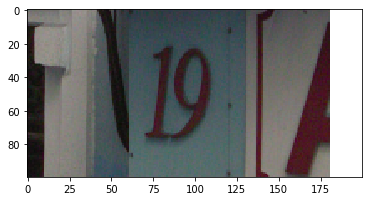

In [9]:
img = resize_img(image_file['train'],0)
img_show(img)

## 从结构文件中读取信息

In [10]:
def get_attrs(digit_struct_mat_file, index):
    """
    Returns a dictionary which contains keys: label, left, top, width and height, each key has multiple values.
    """
    attrs = {}
    f = digit_struct_mat_file
    item = f['digitStruct']['bbox'][index].item()
    for key in ['label', 'left', 'top', 'width', 'height']:
        attr = f[item][key]
        values = [f[attr[()][i].item()][()][0][0] # 此处[()]是因为h5py的要求 不然有warning
                for i in range(len(attr))] if len(attr) > 1 else [attr[()][0][0]]
        attrs[key] = values
    return attrs
def get_box_loc(path_to_digit_struct_mat_file,index):
    """
        得到图片的边界信息
        path_to_digit_struct_mat_file：原数据集边界信息存储mat目录
        index（int）:索引
    """
    def list_pro(a,b):
        c = []
        for i in range(len(a)):
             c.append(float(a[i]+b[i])/2)
        return c
    with h5py.File(path_to_digit_struct_mat_file, 'r') as digit_struct_mat_file:
        attrs = get_attrs(digit_struct_mat_file, index)
        length = len(attrs['label'])
        attrs_left, attrs_top, attrs_width, attrs_height = map(lambda x: [int(i) for i in x],
                                                            [attrs['left'], attrs['top'], attrs['width'], attrs['height']])
    attrs_right = [attrs_left[i]+attrs_width[i] for i in range(length)]
    attrs_bottom = [attrs_top[i]+attrs_height[i] for i in range(length)]
    x_center = list_pro(attrs_left,attrs_right)
    y_center = list_pro(attrs_top,attrs_bottom)
    return  x_center,y_center ,attrs_width,attrs_height,[int(i) for i in attrs['label']]



In [11]:
get_box_loc(datafile['origenal_digit_struct_train'],0)

([286.5, 371.0], [186.5, 190.5], [81, 96], [219, 219], [1, 9])

## 制造符合yolov5的数据文件

In [20]:
def make_labels(image_file,datafile,index,mode = 'train',img_size = (200,100)):
    height,width,_= get_img_size(image_file,index)
    if mode == 'train':
        path_to_digit_struct_mat_file = datafile['origenal_digit_struct_train']
        write_label_path = datafile['YOLO_train_label']
        write_image_path = datafile['YOLO_train']
    elif mode == 'test' :
        path_to_digit_struct_mat_file = datafile['origenal_digit_struct_test']
        write_label_path = datafile['YOLO_test_label']
        write_image_path = datafile['YOLO_test']
    elif mode == 'valid':
        path_to_digit_struct_mat_file = datafile['origenal_digit_struct_train']
        write_label_path = datafile['YOLO_valid_label']
        write_image_path = datafile['YOLO_valid']
        
    filename = image_file[index].split('\\')[-1].split('.')[0]
    # 图像处理及保存
    img = resize_img(image_file,index,img_size = (200,100))
    cv2.imencode('.png', img)[1].tofile(os.path.join(write_image_path,image_file[index].split('\\')[-1])) # 存储成功
    # 结构数据处理及保存
    x_center,y_center ,attrs_width,attrs_height ,labels = get_box_loc(path_to_digit_struct_mat_file,index)    
    total = []
    for i in range(len(labels)):
        x_center[i] = x_center[i]/width
        y_center[i] = y_center[i]/height
        attrs_width[i] = attrs_width[i]/width
        attrs_height[i]=attrs_height[i]/height
        total.append( [labels[i],x_center[i],y_center[i],attrs_width[i],attrs_height[i]])
    with open(os.path.join(write_label_path,filename+'.txt'),'w') as f:
        for i in range(len(total)):
            n =0
            for j in total[i]:
                n = n+1
                if n == 1:
                    if j == 10:
                        j=0
                    f.write(str(j)+' ')
                else:
                    f.write(str(j)[0:5]+' ')
            f.write('\n')
    
    return True

In [13]:
def deal_all(image_file,datafile,mode ='train'):
    if mode == 'train':
        for i in image_train_index:
            make_labels(image_file['train'],datafile,i,mode='train')
        print('process train data sucessfully')
    elif mode == 'valid':
        for i in image_valid_index_:
            make_labels(image_file['train'],datafile,i,mode='valid')
        print('process valid data sucessfully')
    elif mode =='test':
        for i in range(len(image_file['test'])):
            make_labels(image_file['test'],datafile,i,mode='test')
        print('process test data sucessfully')
    else:
        print('mode commond error')

In [21]:
deal_all(image_file,datafile)
deal_all(image_file,datafile,'valid')
deal_all(image_file,datafile,'test')

process train data sucessfully
process valid data sucessfully
process test data sucessfully


process test data sucessfully
